# DistilBERT German: Experiments across modality, time and country

**Outline:**   
DistilBERT German trained on data expect country specified in variable "country_name" (options: ['Luxembourg' 'Italy' 'Germany' 'Austria' 'Switzerland'])

## Loading the packages, functions and dataset

In [ ]:
# select one country as test set 
country_name = "Switzerland"

In [ ]:
# save results in...
path_results = './drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/'+ country_name

In [ ]:
# Load google drive. 
# Note: Working directory might need to be changed if run on your computer.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
! pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# set wroking directory
import sys  
sys.path.insert(0, '/content/drive/MyDrive/Paper BERT/notebooks')
from BERT_utils import *

In [ ]:
# set seeds for reproducibility
transformers.set_seed(3)
transformers.enable_full_determinism(3)
np.random.seed(3)

In [ ]:
# load data
path_file = './drive/MyDrive/Paper BERT/data/multilingual_data_2018-2.csv'
data = pd.read_csv(path_file,  index_col=None)

# ensure variables as string
data['topic_8'] = data['topic_8'].astype(str) # categories
data['text'] = data['text'].astype(str) # topic

In [ ]:
# select German speaking countries
data_german = data.loc[data['language'] =="german", :]
print(data_german.shape)
print(data_german['countryname'].unique())
data_german.head(3) 

(130888, 7)
['Luxembourg' 'Italy' 'Germany' 'Austria' 'Switzerland']


,countryname,text,language,code,document_index,date,topic_8
201186,Luxembourg,Wir wollen in einer modernen Gesellschaft und ...,german,202.0,3,201310,freedom and democracy
201187,Luxembourg,"Wir wollen eine offene Gesellschaft, die alle ...",german,503.0,3,201310,welfare and quality of life
201188,Luxembourg,Wir wollen unsere Demokratie wiederbeleben.,german,202.0,3,201310,freedom and democracy


## Train-Test-Validation data sets

In [ ]:
# X: text, Y: topic
X = data_german['text'] 
Y = data_german['topic_8']

# Y numeric
Y_numeric = pd.factorize(Y)[0]
classes = pd.factorize(Y)[1]

# mapping: numeric -> category
dic_y_mapping = {n:label for n,label in enumerate(classes)}

# reverese mapping: catgory -> numeric
dic_y_mapping_inverse = dict(map(reversed, dic_y_mapping.items()))

In [ ]:
# select one country as test set 
X_train = X[data_german['countryname'] != country_name]
X_test = X[data_german['countryname'] == country_name]

Y_train = Y_numeric[data_german['countryname'] != country_name] # numeric encoding
Y_test = Y_numeric[data_german['countryname'] == country_name] # numeric endcoding

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

print(Y_test.shape[0]/ data.shape[0])


X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, train_size=0.8, random_state=77)

print('X_train', X_train.shape, round(X_train.shape[0]/X.shape[0], 2))
print('X_test', X_test.shape, round(X_test.shape[0]/X.shape[0], 2))
print('X_val', X_val.shape, round(X_val.shape[0]/X.shape[0], 2))

(117173,)
(13715,)
(117173,)
(13715,)
0.013769969719118721
X_train (93738,) 0.72
X_test (13715,) 0.1
X_val (23435,) 0.18


In [ ]:
# create dataset for training
dataset = {'train':Dataset.from_dict({'label':Y_train,'text':X_train}),
     'validation':Dataset.from_dict({'label':Y_val,'text':X_val}),
     'test':Dataset.from_dict({'label':Y_test,'text':X_test})
     }
dataset = DatasetDict(dataset)

# structure data set
print(dataset)

# example
dataset["train"][0]

DatasetDict({
    train: Dataset({
        features: ['label', 'text'],
        num_rows: 93738
    })
    validation: Dataset({
        features: ['label', 'text'],
        num_rows: 23435
    })
    test: Dataset({
        features: ['label', 'text'],
        num_rows: 13715
    })
})


{'label': 0,
 'text': 'Auf der anderen Seite lehnt es die FDP ab, dass eine immer weitere Herabsenkung der polizeilichen Eingriffsschwellen im Rahmen von Bundes- und Landesgesetzen erfolgt.'}

## Preprocessing the data

In [ ]:
# Chose model and corresponing tokenize
model_checkpoint = "distilbert-base-german-cased"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=True)
batch_size = 16

In [ ]:
# Encode data set
def preprocess_function(examples):
  return tokenizer(examples['text'], truncation=True)
# Note truncation=True: input truncated to the maximum length accepted by the model

encoded_dataset = dataset.map(preprocess_function, batched=True)
encoded_dataset

Map:   0%|          | 0/93738 [00:00<?, ? examples/s]

Map:   0%|          | 0/23435 [00:00<?, ? examples/s]

Map:   0%|          | 0/13715 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 93738
    })
    validation: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 23435
    })
    test: Dataset({
        features: ['label', 'text', 'input_ids', 'attention_mask'],
        num_rows: 13715
    })
})

## Fine-tuning the model

Fine-tuning with huggingface trainer: https://huggingface.co/transformers/v3.0.2/main_classes/trainer.html

In [ ]:
metric = load_metric('f1')
metric_name = "f1"
num_labels = 8
model = AutoModelForSequenceClassification.from_pretrained(model_checkpoint, num_labels=num_labels)
model_name = model_checkpoint.split("/")[-1]

<ipython-input-14-47b4617a7a88>:1: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric('f1')
Some weights of the model checkpoint at distilbert-base-german-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassif

In [ ]:
args = TrainingArguments(
    f"{model_name}-finetuned",
    evaluation_strategy = "epoch",
    save_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    load_best_model_at_end=True,
    metric_for_best_model=metric_name,
    seed=0,
    #push_to_hub=True,
)

In [ ]:
trainer = Trainer(
    model,
    args,
    train_dataset=encoded_dataset["train"],
    eval_dataset=encoded_dataset["validation"],
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,F1
1,0.988000,0.986676,0.552672
2,0.864700,0.973092,0.560915
3,0.732200,1.003634,0.562291


TrainOutput(global_step=17577, training_loss=0.9034481379551347, metrics={'train_runtime': 2349.0843, 'train_samples_per_second': 119.712, 'train_steps_per_second': 7.482, 'total_flos': 3434817654264000.0, 'train_loss': 0.9034481379551347, 'epoch': 3.0})

In [ ]:
# https://www.thepythoncode.com/article/finetuning-bert-using-huggingface-transformers-python
# saving the fine tuned model & tokenizer
model_path = path_results + "/model"
model.save_pretrained(model_path)
tokenizer.save_pretrained(model_path)

('./drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/Switzerland/model/tokenizer_config.json',
 './drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/Switzerland/model/special_tokens_map.json',
 './drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/Switzerland/model/vocab.txt',
 './drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/Switzerland/model/added_tokens.json',
 './drive/MyDrive/Paper BERT/results/02_DistilBERT German/countries/Switzerland/model/tokenizer.json')

## Evaluation

### Evaluation on training

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["train"])

{'eval_loss': 0.6342772841453552,
 'eval_f1': 0.6807125386118138,
 'eval_runtime': 189.222,
 'eval_samples_per_second': 495.386,
 'eval_steps_per_second': 30.964,
 'epoch': 3.0}

In [ ]:
def predict_BERT(encoded_dataset, dic_y_mapping, Y_train):
  #https://discuss.huggingface.co/t/different-results-predicting-from-trainer-and-model/12922/4
  #https://towardsdatascience.com/fine-tuning-pretrained-nlp-models-with-huggingfaces-trainer-6326a4456e7b
  # Make prediction
  raw_pred, _, _ = trainer.predict(encoded_dataset)

  # Preprocess raw predictions
  Y_pred = np.argmax(raw_pred, axis=1)

  # prediction
  Y_pred = [dic_y_mapping[y_train] for y_train in Y_pred]
  Y_pred = np.array(Y_pred, dtype= 'object')

  # true values
  Y_classes = [dic_y_mapping[y_train] for y_train in Y_train]
  Y_classes = np.array(Y_classes, dtype= 'object')
  return Y_pred, Y_classes


In [ ]:
Y_pred_training, Y_train_classes = predict_BERT(encoded_dataset["train"], dic_y_mapping, Y_train)
evaluation_training = evaluation_table(Y_train_classes,  Y_pred_training, domain= 'within-domain', data_description ="training")
evaluation_training 

,metric,score,domain,data
0,Accuracy,0.784228,within-domain,training
1,F1 score (macro),0.680713,within-domain,training


### Evaluation on validation data

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["validation"])

{'eval_loss': 1.0036336183547974,
 'eval_f1': 0.5622907071220535,
 'eval_runtime': 47.4318,
 'eval_samples_per_second': 494.078,
 'eval_steps_per_second': 30.886,
 'epoch': 3.0}

In [ ]:
Y_pred_validation, Y_val_classes = predict_BERT(encoded_dataset["validation"], dic_y_mapping, Y_val)
evaluation_validation = evaluation_table(Y_val_classes,  Y_pred_validation, domain= 'within-domain', data_description ="validation")
evaluation_validation 

,metric,score,domain,data
0,Accuracy,0.656155,within-domain,validation
1,F1 score (macro),0.562291,within-domain,validation


### Evaluation on test set

In [ ]:
trainer.evaluate(eval_dataset = encoded_dataset["test"])

{'eval_loss': 1.2880966663360596,
 'eval_f1': 0.48782628780185,
 'eval_runtime': 26.5641,
 'eval_samples_per_second': 516.299,
 'eval_steps_per_second': 32.299,
 'epoch': 3.0}

In [ ]:
# get predictions and evaluation metrices
Y_pred_testing, Y_test_classes = predict_BERT(encoded_dataset["test"], dic_y_mapping, Y_test)
evaluation_testing = evaluation_table(Y_test_classes, Y_pred_testing, domain= 'within-domain', data_description ="testing")
evaluation_testing 

,metric,score,domain,data
0,Accuracy,0.575428,within-domain,testing
1,F1 score (macro),0.487826,within-domain,testing


Accuracy: 0.58
Detail:


/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,precision,recall,f1-score,support,data
economy,0.537522,0.599270,0.566719,3012.0,testing
external relations,0.765805,0.668758,0.713999,1594.0,testing
fabric of society,0.650490,0.591827,0.619774,2129.0,testing
freedom and democracy,0.443478,0.600000,0.510000,765.0,testing
no topic,0.000000,0.000000,0.000000,169.0,testing
political system,0.430837,0.404801,0.417414,1208.0,testing
social groups,0.444656,0.485417,0.464143,960.0,testing
welfare and quality of life,0.616010,0.605209,0.610562,3878.0,testing


<Figure size 640x480 with 0 Axes>

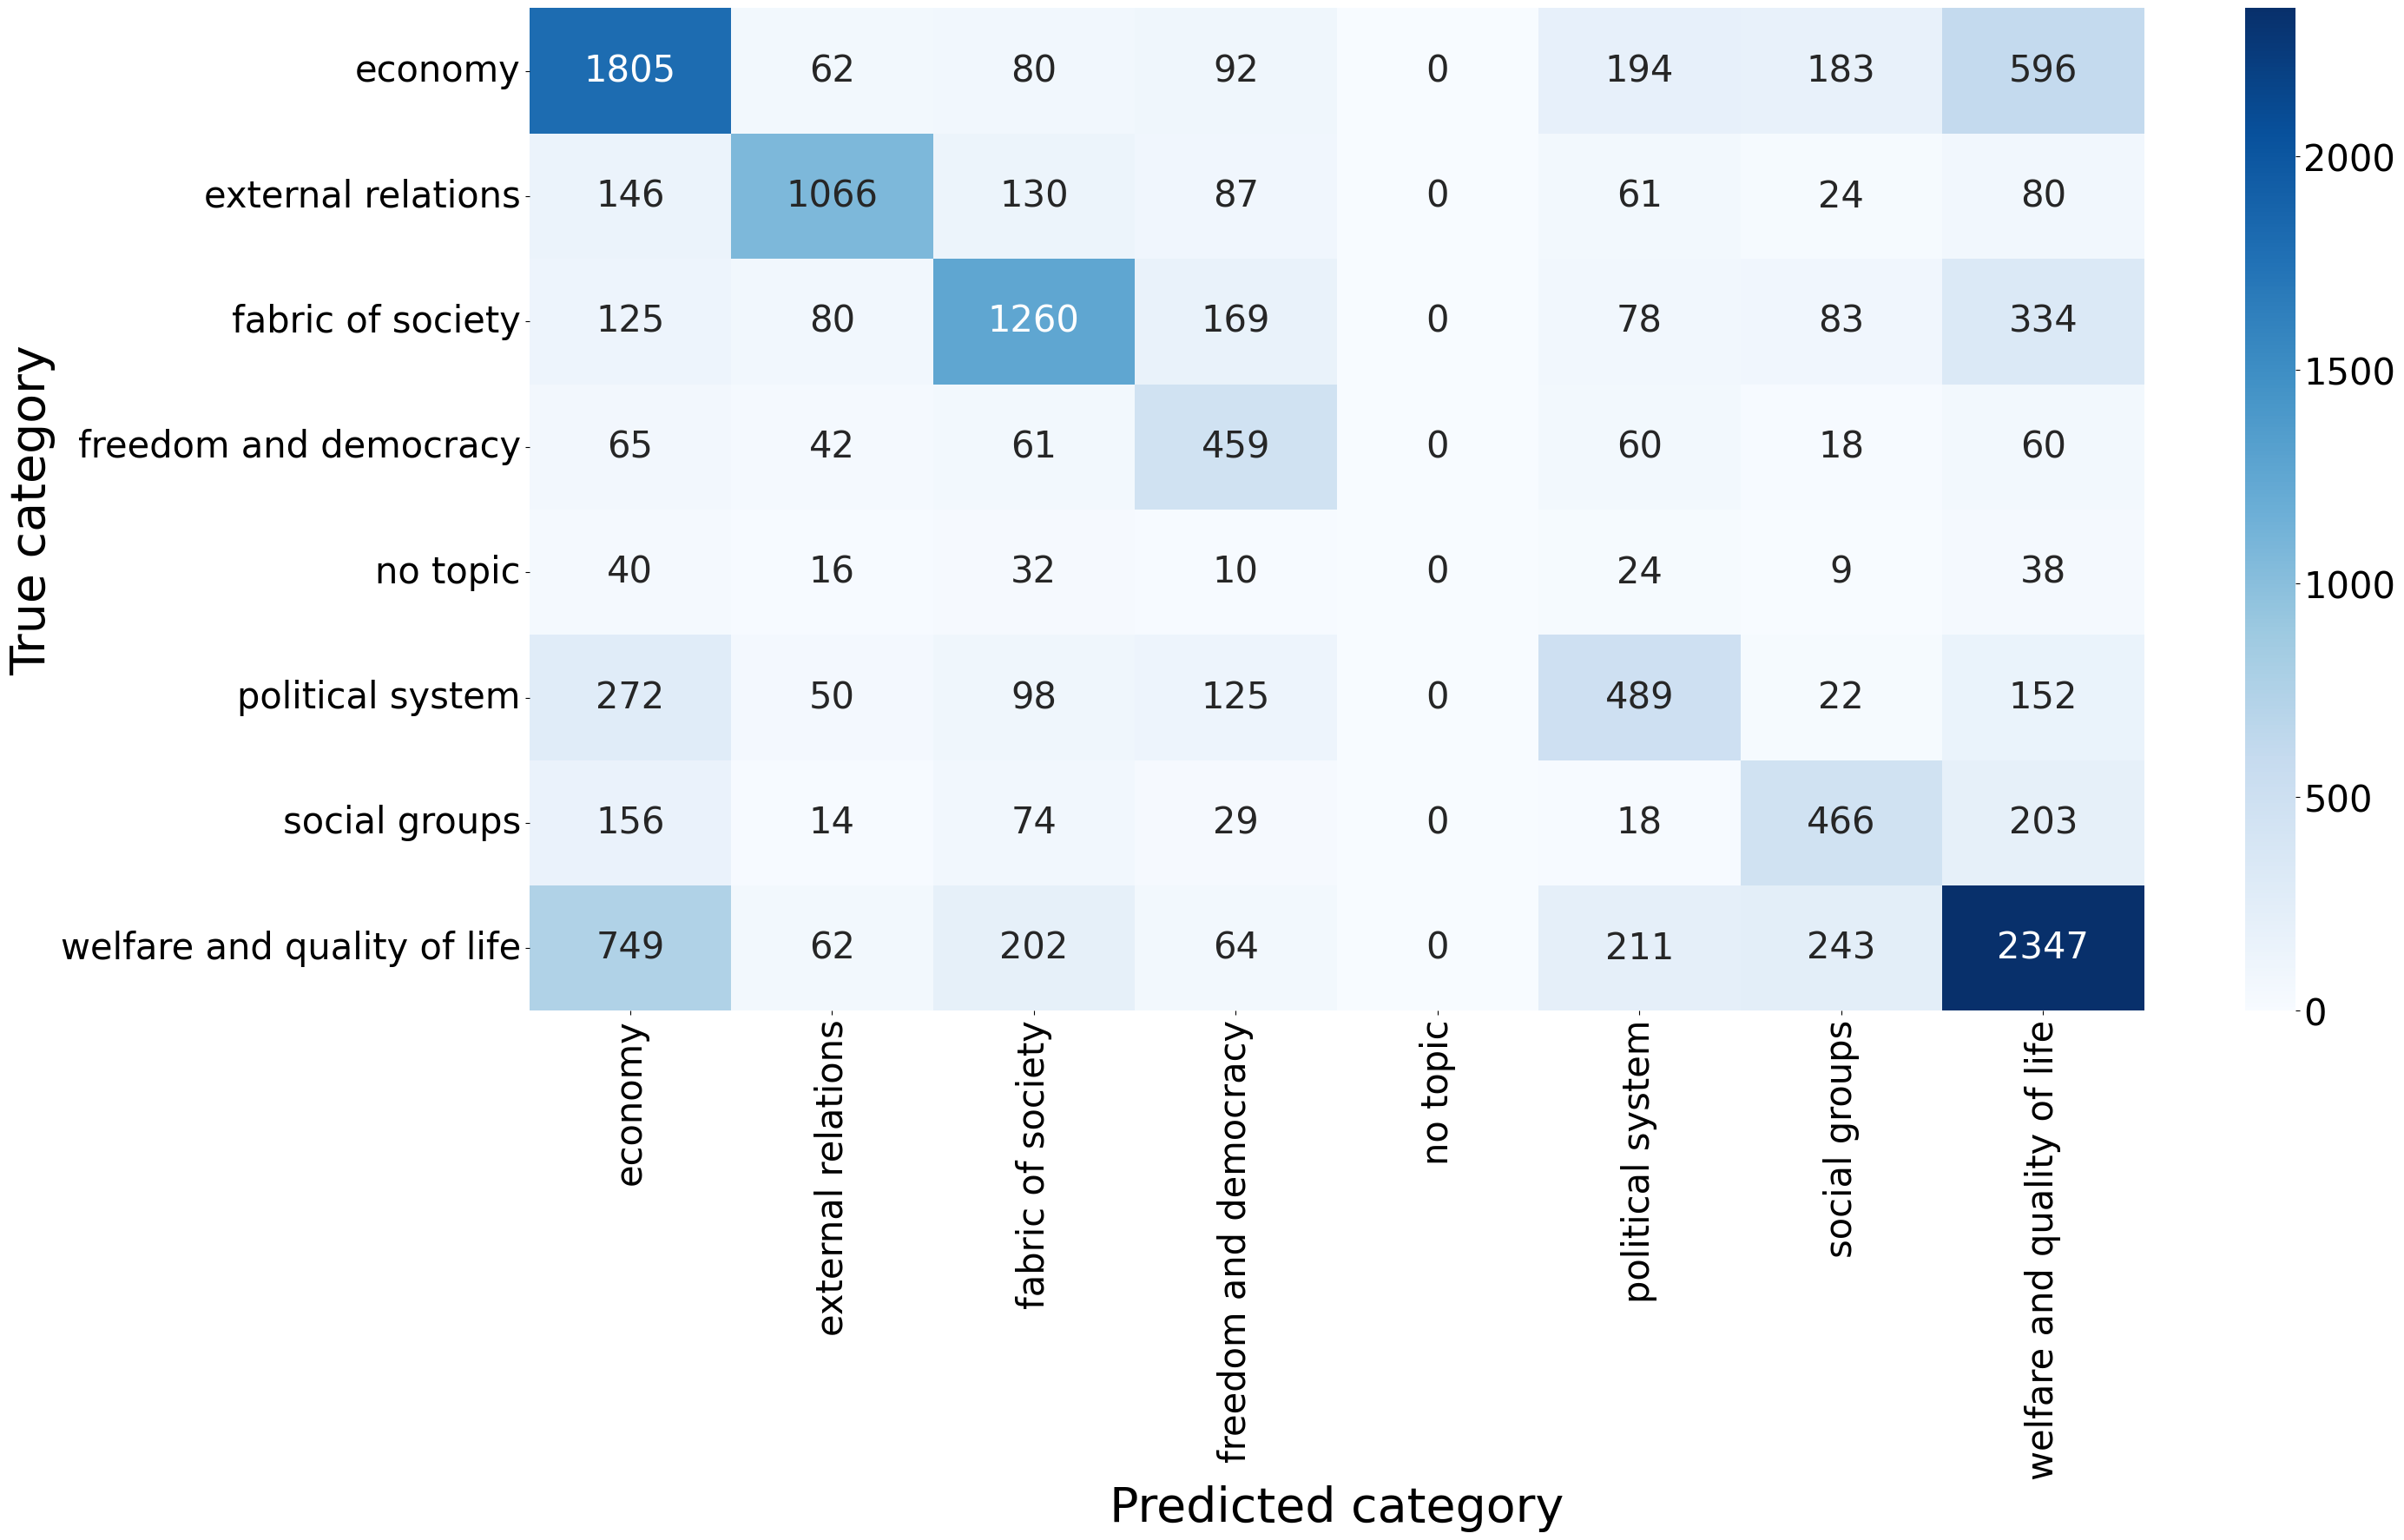

In [ ]:
classification_report_testing = evaluation_per_category(Y_test_classes, Y_pred_testing, data_description ="testing", path_results = path_results, figsize=(30,15))
classification_report_testing

## Overview results Exp 1-3

In [ ]:
eval_metrics = pd.concat([evaluation_training, evaluation_validation, evaluation_testing])
eval_metrics.reset_index(drop = True, inplace = True)
eval_metrics.to_csv(path_results + '/eval_metrics.csv')
eval_metrics

,metric,score,domain,data
0,Accuracy,0.784228,within-domain,training
1,F1 score (macro),0.680713,within-domain,training
2,Accuracy,0.656155,within-domain,validation
3,F1 score (macro),0.562291,within-domain,validation
4,Accuracy,0.575428,within-domain,testing
5,F1 score (macro),0.487826,within-domain,testing


# Packages

In [ ]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

transformers==4.27.4
pandas==1.4.4
numpy==1.22.4
seaborn==0.12.2


In [ ]:
!pip list -v

Package                       Version              Location                               Installer
----------------------------- -------------------- -------------------------------------- ---------
absl-py                       1.4.0                /usr/local/lib/python3.9/dist-packages pip
aiohttp                       3.8.4                /usr/local/lib/python3.9/dist-packages pip
aiosignal                     1.3.1                /usr/local/lib/python3.9/dist-packages pip
alabaster                     0.7.13               /usr/local/lib/python3.9/dist-packages pip
albumentations                1.2.1                /usr/local/lib/python3.9/dist-packages pip
altair                        4.2.2                /usr/local/lib/python3.9/dist-packages pip
anyio                         3.6.2                /usr/local/lib/python3.9/dist-packages pip
appdirs                       1.4.4                /usr/local/lib/python3.9/dist-packages pip
argon2-cffi                   21.3.0            